In [3]:
#!pip install fasttext
!rm -rf ReST/
!rm twitter128.bin
!git clone https://github.com/alessandrocuda/ReSt
!wget http://www.italianlp.it/twitter128.bin
!mv /content/twitter128.bin /content/ReSt/results/model/word2vec

rm: cannot remove 'twitter128.bin': No such file or directory
fatal: destination path 'ReSt' already exists and is not an empty directory.
--2021-06-18 19:46:59--  http://www.italianlp.it/twitter128.bin
Resolving www.italianlp.it (www.italianlp.it)... 146.48.92.46, 2a00:1620:c0:5c::8
Connecting to www.italianlp.it (www.italianlp.it)|146.48.92.46|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 613808129 (585M) [application/octet-stream]
Saving to: ‘twitter128.bin’

twitter128.bin      100%[===================>] 585.37M  13.2MB/s    in 46s     

2021-06-18 19:47:45 (12.8 MB/s) - ‘twitter128.bin’ saved [613808129/613808129]



In [2]:
import tensorflow as tf
#import tensorflow_addons as tfa

from tensorflow.keras import backend as K

#from tensorflow.keras.engine import Layer, InputSpec, InputLayer

from tensorflow.keras.models import Model, Sequential

from tensorflow.keras.layers import Dropout, Embedding, concatenate
from tensorflow.keras.layers import Conv1D, MaxPool1D, Conv2D, MaxPool2D, ZeroPadding1D, GlobalMaxPool1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Dense, Input, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Concatenate, Dot, Concatenate, Multiply, RepeatVector
from tensorflow.keras.layers import Bidirectional, TimeDistributed
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Lambda, Permute
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, f1_score

from gensim.models import KeyedVectors
from gensim.models import Word2Vec

#import fasttext.util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from gensim.test.utils import datapath

import sys
#root_project = "/content/ReSt/"
root_project = "/Users/Alessandro/Dev/repos/ReSt/"
#root_project = "/home/jupyter/ReSt/"
sys.path.append(root_project)
from src.data.utils import load_csv_to_dict, set_unkmark_token, load_data, to_emb
from src.data.word_embedding import get_index_key_association, get_int_seq, build_keras_embedding_matrix, get_data_to_emb, get_index_key_pos_association, get_one_hot_pos

%load_ext autoreload
%autoreload 2

In [3]:
print(tf.__version__)

2.4.1


# Path

In [4]:
#PATH
dataset_dev_path           = root_project + "dataset/haspeede2/preprocessed/dev/dev.csv"
dataset_test_tweets_path   = root_project + "dataset/haspeede2/preprocessed/reference/reference_tweets.csv"
#w2v_bin_path               = "/content/twitter128.bin"
w2v_bin_path               = root_project + 'results/model/word2vec/twitter128.bin'

# Embedding

In [7]:
#load word2vec and embedding_matrix
w2v = KeyedVectors.load_word2vec_format(datapath(w2v_bin_path), binary=True)
index_to_key, key_to_index = get_index_key_association(w2v)
embedding_matrix, vocab_size = build_keras_embedding_matrix(w2v, index_to_key)

WORD_EMB_SIZE = 128
VOCAB_SIZE = vocab_size

Vocab_size is 1170776
Embedding_matrix with unk word loaded
Shape (1170777, 128)


# DATA

In [8]:
#load dataset dictionary
dataset_dev = load_csv_to_dict(dataset_dev_path)
dataset_test_tweets = load_csv_to_dict(dataset_test_tweets_path)

In [9]:
def load_data(dataset_dict, w2v, key_to_index, embedding_matrix, max_text_len):
    #TODO: deve ritornare anche tutto il resto, extra, lemma, stem, ...
    senteces = dataset_dict["tokens"]
    X = dataset_dict["tokens"]
    X = set_unkmark_token(X, w2v)
    X = get_int_seq(X, key_to_index)
    X = pad_sequences(X, maxlen=MAX_TEXT_LEN, padding='post', truncating='post')
    X = np.array(X)
    y = np.array(dataset_dict["stereotype"])
    return X, y

def to_emb(X):
    return np.array([ [ embedding_matrix[index_word] for index_word in sentence] for sentence in X])

In [10]:
#load dev/test
MAX_TEXT_LEN = 65

X, y = load_data(dataset_dev, w2v, key_to_index,embedding_matrix, MAX_TEXT_LEN)
X_e = to_emb(X)
X_test, y_test = load_data(dataset_test_tweets, w2v, key_to_index, embedding_matrix, MAX_TEXT_LEN)
X_test_e = to_emb(X_test)

# Split

In [33]:
X_train, X_val, y_train, y_val = train_test_split(X_e, y, test_size=0.10, random_state=128)

# Metrics

In [11]:
def f1_sklean_mapping_macro(y_true, y_pred):
    return f1_score(y_true, y_pred, average="macro")

def f1_macro(y_true, y_pred):
    return tf.py_function(f1_sklean_mapping_macro, (y_true, K.round(y_pred)), tf.double)

# callback

In [12]:
class FCallback(tf.keras.callbacks.Callback):
  
    def __init__(self, validation = (), verbose = 0):
        self.validation = validation
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.f1 = []
        self.val_f1 = []
    def on_epoch_end(self, epoch, logs=None):
        y_t =  self.validation[1]
        y_p =  np.where(self.model.predict(self.validation[0]) > 0.5, 1, 0)
        logs['val_f1'] =  f1_score(y_t, y_p, average='macro')
        if self.verbose >0:
            print("— val_f1: {}".format(logs['val_f1']))

class GapCallback(tf.keras.callbacks.Callback):
  
    def __init__(self, train = (), validation = (), verbose = 0):
        self.train = train
        self.validation = validation
        self.verbose = verbose

    def on_train_begin(self, logs={}):
        self.gap = []
        self.val_gap = []
    def on_epoch_end(self, epoch, logs=None):
        y_t =  self.validation[1]
        y_p =  np.where(self.model.predict(self.validation[0]) > 0.5, 1, 0)
        val_f1 = f1_score(y_t, y_p, average='macro')
        y_t =  self.train[1]
        y_p =  np.where(self.model.predict(self.train[0]) > 0.5, 1, 0)
        f1 = f1_score(y_t, y_p, average='macro')
        logs['val_gap_f1'] =  np.abs( f1 - val_f1)
        if self.verbose >0:
            print("— val_gap_f1: {}".format(logs['val_gap_f1']))

class ReturnBestEarlyStopping(EarlyStopping):
    def __init__(self, **kwargs):
        super(ReturnBestEarlyStopping, self).__init__(**kwargs)

    def on_train_end(self, logs=None):
        if self.stopped_epoch > 0:
            if self.verbose > 0:
                print(f'\nEpoch {self.stopped_epoch + 1}: early stopping')
        elif self.restore_best_weights:
            if self.verbose > 0:
                print('Restoring model weights from the end of the best epoch.')
            self.model.set_weights(self.best_weights)

# KIM-CNN

In [13]:
def kim_cnn(input_shape, filters = 256, filter_sizes = [2,4,6], dropout = 0.5, hn=128, lr=0.01, print_model=False):
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Dropout
    from tensorflow.keras.layers import Conv1D, GlobalMaxPool1D
    from tensorflow.keras.layers import Dense, Input, Flatten, Activation
    from tensorflow.keras.layers import Concatenate
    from tensorflow.keras.regularizers import l2

    """ HyperParameters """

    text_seq_input = Input(shape=input_shape, name="text")

    convs = []
    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=filters, kernel_size=filter_size)(text_seq_input)
        l_relu = Activation("relu")(l_conv)
        l_pool = GlobalMaxPool1D()(l_relu)   
        convs.append(l_pool)

    l_merge     = Concatenate(axis=1)(convs)

    l_flat      = Flatten()(l_merge)
    l_drop      = Dropout(dropout)(l_flat)
    l_hidden    = Dense(hn, activation='relu')(l_drop)
    l_drop      = Dropout(dropout)(l_hidden)
    l_out_st    = Dense(1, activation='sigmoid', name="st")(l_drop)  #dims output

    model_cnn   = Model(inputs=text_seq_input, outputs=l_out_st)
    if print_model:
        model_cnn.summary()
        tf.keras.utils.plot_model(model_cnn, "my_first_model.png", show_shapes=True)
    
    model_cnn.compile(
        loss= tf.keras.losses.BinaryCrossentropy(),#(from_logits=True),
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr, amsgrad=False),
        metrics= [f1_macro]
    )

    return model_cnn

In [18]:
#del model
model = kim_cnn((65,128, ), filters = 256, filter_sizes = [2,4,6], dropout = 0.5, hn=128, lr=0.01, print_model=False)

In [19]:
model.compile(
    loss= tf.keras.losses.BinaryCrossentropy(from_logits=True),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=False),
    #optimizer = tf.keras.optimizers.SGD(learning_rate=0.07, momentum=0, nesterov=False),
    metrics=[f1_macro]
)
#mc = ModelCheckpoint('best_model.h5', monitor='val_f1_macro', mode='max', save_best_only=True, verbose=1)
#es = EarlyStopping(monitor="val_f1_macro", min_delta=0, patience=200, verbose=1, mode="max", restore_best_weights=False)
f1_callback = FCallback(validation = (X_test_e, y_test), verbose=True)                                   
best_callback = ReturnBestEarlyStopping(monitor="val_f1_macro", min_delta=0, patience=100, verbose=1, mode="max", restore_best_weights=True)

history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val), callbacks=[f1_callback, best_callback], verbose = 1)
#model_cnn = load_model('best_model.h5', custom_objects={'f1_macro': f1_macro})

Epoch 1/200


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/backend.py:5017: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


49/49 [==============================] - 31s 21ms/step - loss: 0.9738 - f1_macro: 0.4983 - val_loss: 0.6924 - val_f1_macro: 0.3516
— val_f1: 0.35462442514052117
Epoch 2/200
49/49 [==============================] - 1s 15ms/step - loss: 0.6883 - f1_macro: 0.4674 - val_loss: 0.6801 - val_f1_macro: 0.3516
— val_f1: 0.35462442514052117
Epoch 3/200
49/49 [==============================] - 1s 14ms/step - loss: 0.6748 - f1_macro: 0.4393 - val_loss: 0.6668 - val_f1_macro: 0.3576
— val_f1: 0.36198913291826124
Epoch 4/200
49/49 [==============================] - 1s 14ms/step - loss: 0.6535 - f1_macro: 0.5401 - val_loss: 0.6402 - val_f1_macro: 0.4790
— val_f1: 0.5359709752233117
Epoch 5/200
49/49 [==============================] - 1s 15ms/step - loss: 0.6467 - f1_macro: 0.5817 - val_loss: 0.6284 - val_f1_macro: 0.5724
— val_f1: 0.6130058689042355
Epoch 6/200
49/49 [==============================] - 1s 14ms/step - loss: 0.6249 - f1_macro: 0.6165 - val_loss: 0.6165 - val_f1_macro: 0.6686
— val_f1: 0

In [20]:
y_val_pred = np.where(model.predict(X_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.714467371828218
              precision    recall  f1-score   support

           0       0.75      0.70      0.73       369
           1       0.68      0.73      0.70       315

    accuracy                           0.71       684
   macro avg       0.71      0.72      0.71       684
weighted avg       0.72      0.71      0.72       684



In [21]:
y_test_pred = np.where(model.predict(X_test_e) > 0.5, 1, 0)
print(y_test.shape)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

(1263,)
0.6780973784652471
              precision    recall  f1-score   support

           0       0.78      0.58      0.67       694
           1       0.61      0.79      0.69       569

    accuracy                           0.68      1263
   macro avg       0.69      0.69      0.68      1263
weighted avg       0.70      0.68      0.68      1263



|        	|        	|              	|    0   	|        	|        	|    1   	|        	|        	|          	|
|--------	|--------	|--------------	|:------:	|:------:	|:------:	|:------:	|:------:	|:------:	|:--------:	|
|        	|        	|              	|    P   	|    R   	|   F1   	|    P   	|    R   	|   F1   	| **Macro-F1** 	|
| **TASK B** 	|  **News**  	| Baseline_MFC 	|   0,65 	|      1 	| 0,7878 	|      0 	|      0 	|      0 	|   0,3939 	|
|        	|        	| Baseline_SVC 	| 0,7467 	| 0,8707 	| 0,8039 	| 0,6528 	| 0,4514 	| 0,5337 	|   0,6688 	|
|        	| **Tweets** 	| Baseline_MFC 	| 0,5494 	|      1 	| 0,7092 	|      0 	|      0 	|      0 	|   0,3546 	|
|        	|        	| Baseline_SVC 	| 0,7869 	| 0,6599 	| 0,7178 	| 0,6534 	|  0,782 	|  0,712 	|   0,7149 	|

dict_keys(['loss', 'f1_macro', 'val_loss', 'val_f1_macro', 'val_f1'])


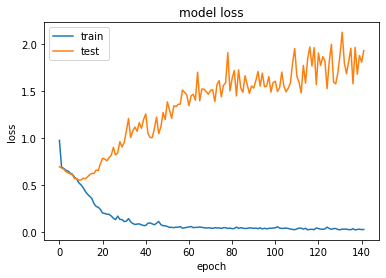

In [22]:
print(history.history.keys())
# summarize history for accuracy

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Result GridSearch

In [6]:
import pickle

grid_result0 = pickle.load( open( "../../script/grid_search/kim_cnn/result_kim_cnn_0.p", "rb" ) )
grid_result1 = pickle.load( open( "../../script/grid_search/kim_cnn/result_kim_cnn_1.p", "rb" ) )
grid_result2 = pickle.load( open( "../../script/grid_search/kim_cnn/result_kim_cnn_2.p", "rb" ) )

In [7]:
grid_result0[0]

{'hyper_parm': {'filters': 32,
  'filter_sizes': [2, 3, 4],
  'dropout': 0.1,
  'hn': 64,
  'lr': 0.1},
 'mean': 0.3568288921589145,
 'std': 0.005373049976030892,
 'folds': {'fold_0': {'f1': 0.35859186796911474,
   'val_f1': 0.34888148500713945},
  'fold_1': {'f1': 0.3553483553483553, 'val_f1': 0.36490250696378834},
  'fold_2': {'f1': 0.355181347150259, 'val_f1': 0.35985025737014503},
  'fold_3': {'f1': 0.356348590638738, 'val_f1': 0.35623529411764704},
  'fold_4': {'f1': 0.35854161298634374, 'val_f1': 0.35427491733585265}}}

In [8]:
grid_result_d = {
    'hyper_parm' : [],
    'mean': [],
    'std': [],
    'folds': []
}
for elem in grid_result0:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])
for elem in grid_result1:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])
for elem in grid_result2:
    for k in grid_result_d:
        grid_result_d[k].append(elem[k])

In [9]:
df_result = pd.DataFrame(grid_result_d)

In [10]:
pd.set_option('display.max_colwidth', None)
df_result.sort_values(by=['mean'], ascending=False)[0:20][["hyper_parm","mean", "std"]]

,hyper_parm,mean,std
231,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.0001}",0.705910,0.004856
218,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.1, 'hn': 64, 'lr': 0.001}",0.703817,0.011898
234,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.001}",0.703300,0.005910
254,"{'filters': 256, 'filter_sizes': [3, 4, 5], 'dropout': 0.1, 'hn': 64, 'lr': 0.001}",0.698973,0.009021
127,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.698614,0.010202
274,"{'filters': 256, 'filter_sizes': [3, 4, 5], 'dropout': 0.5, 'hn': 512, 'lr': 0.001}",0.698546,0.007799
271,"{'filters': 256, 'filter_sizes': [3, 4, 5], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.698533,0.012795
14,"{'filters': 32, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.698085,0.015261
230,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.697862,0.013440
126,"{'filters': 128, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.001}",0.697779,0.010987


In [13]:
grid_result_final = pickle.load( open( "../../script/grid_search/kim_cnn/result_kim_cnn.p", "rb" ) )

In [17]:
grid_result_final[0]

{'hyper_parm': {'filters': 256,
  'filter_sizes': [2, 3, 4],
  'dropout': 0.1,
  'hn': 64,
  'lr': 0.001},
 'loss_mean': 0.37758823931217195,
 'loss_std': 0.07894720316803756,
 'f1_macro_mean': 0.8579907026812166,
 'f1_macro_std': 0.04848333480805784,
 'val_loss_mean': 0.5699705719947815,
 'val_loss_std': 0.01121356498155134,
 'val_f1_macro_mean': 0.6917073041699661,
 'val_f1_macro_std': 0.020919188607695562,
 'folds': {'loss': [0.40829095244407654,
   0.37874940037727356,
   0.24003072082996368,
   0.37699511647224426,
   0.48387500643730164],
  'val_loss': [0.5652934312820435,
   0.5511502623558044,
   0.5840681791305542,
   0.5724660158157349,
   0.5768749713897705],
  'f1_macro': [0.8452688141017266,
   0.8704064690929334,
   0.9411648044498737,
   0.8398557347416034,
   0.7932576910199463],
  'val_f1_macro': [0.7074836963209056,
   0.7111122993092789,
   0.7057977302800902,
   0.6584048535069548,
   0.6757379414326008]}}

In [26]:
df_result_final = pd.DataFrame(grid_result_final)
df_result_final_sorted = df_result_final.sort_values(by=['val_f1_macro_mean'], ascending=False)[0:3][["hyper_parm","loss_mean","loss_std","f1_macro_mean", "f1_macro_std","val_loss_mean","val_loss_std","val_f1_macro_mean","val_f1_macro_std"]]

In [27]:
df_result_final_sorted

,hyper_parm,loss_mean,loss_std,f1_macro_mean,f1_macro_std,val_loss_mean,val_loss_std,val_f1_macro_mean,val_f1_macro_std
5,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.0001}",0.376552,0.035755,0.852610,0.018248,0.560757,0.011836,0.702131,0.009217
4,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001}",0.383705,0.068300,0.852852,0.037940,0.571303,0.013317,0.699694,0.009102
7,"{'filters': 256, 'filter_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001}",0.380719,0.025508,0.849036,0.019435,0.562171,0.005032,0.696124,0.007857


In [28]:
print(df_result_final_sorted.to_latex(index=False))

\begin{tabular}{lrrrrrrrr}
\toprule
                                                                          hyper\_parm &  loss\_mean &  loss\_std &  f1\_macro\_mean &  f1\_macro\_std &  val\_loss\_mean &  val\_loss\_std &  val\_f1\_macro\_mean &  val\_f1\_macro\_std \\
\midrule
 \{'filters': 256, 'filter\_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.0001\} &   0.376552 &  0.035755 &       0.852610 &      0.018248 &       0.560757 &      0.011836 &           0.702131 &          0.009217 \\
  \{'filters': 256, 'filter\_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 64, 'lr': 0.001\} &   0.383705 &  0.068300 &       0.852852 &      0.037940 &       0.571303 &      0.013317 &           0.699694 &          0.009102 \\
\{'filters': 256, 'filter\_sizes': [2, 3, 4], 'dropout': 0.5, 'hn': 124, 'lr': 0.0001\} &   0.380719 &  0.025508 &       0.849036 &      0.019435 &       0.562171 &      0.005032 &           0.696124 &          0.007857 \\
\bottomrule
\end{tabular}



In [16]:
model = kim_cnn((65,128, ), filters = 256, filter_sizes = [2,3,4], dropout = 0.4, hn=64, lr=0.0001, print_model=False)
f1_callback = FCallback(validation = (X_val, y_val), verbose=True)    
# gap_callback = GapCallback(train = (X_train, y_train), validation = (X_val, y_val), verbose=True)                               
best_callback = ReturnBestEarlyStopping(monitor="val_f1", min_delta=0, patience=50, verbose=1, mode="max", restore_best_weights=True)
history = model.fit(X_train, y_train, batch_size=128, epochs=200, validation_data=(X_val, y_val), callbacks=[f1_callback, best_callback], verbose = 2)

Epoch 1/200
49/49 - 1s - loss: 1.3231 - f1_macro: 0.4791 - val_loss: 0.7498 - val_f1_macro: 0.3324
— val_f1: 0.32450613350017427
Epoch 2/200
49/49 - 1s - loss: 0.8053 - f1_macro: 0.5106 - val_loss: 0.6908 - val_f1_macro: 0.4708
— val_f1: 0.430370071990002
Epoch 3/200
49/49 - 1s - loss: 0.7272 - f1_macro: 0.5296 - val_loss: 0.6885 - val_f1_macro: 0.5682
— val_f1: 0.5281002843630418
Epoch 4/200
49/49 - 1s - loss: 0.7044 - f1_macro: 0.5258 - val_loss: 0.6890 - val_f1_macro: 0.5374
— val_f1: 0.5210681974152074
Epoch 5/200
49/49 - 1s - loss: 0.6948 - f1_macro: 0.5217 - val_loss: 0.6891 - val_f1_macro: 0.5209
— val_f1: 0.5179648443799387
Epoch 6/200
49/49 - 1s - loss: 0.6971 - f1_macro: 0.5096 - val_loss: 0.6892 - val_f1_macro: 0.5756
— val_f1: 0.5395563891626607
Epoch 7/200
49/49 - 1s - loss: 0.6895 - f1_macro: 0.5177 - val_loss: 0.6882 - val_f1_macro: 0.5336
— val_f1: 0.5172171079687451
Epoch 8/200
49/49 - 1s - loss: 0.6887 - f1_macro: 0.4989 - val_loss: 0.6876 - val_f1_macro: 0.5550
— val

In [17]:
print(history.history.keys())

dict_keys(['loss', 'f1_macro', 'val_loss', 'val_f1_macro', 'val_f1'])


In [18]:
y_train_pred = np.where(model.predict(X_train) > 0.5,1,0)
print(f1_score(y_train, y_train_pred, average="macro"))
print(classification_report(y_train, y_train_pred))

0.9273989790568382
              precision    recall  f1-score   support

           0       0.95      0.92      0.93      3426
           1       0.90      0.94      0.92      2729

    accuracy                           0.93      6155
   macro avg       0.93      0.93      0.93      6155
weighted avg       0.93      0.93      0.93      6155



In [19]:
y_val_pred = np.where(model.predict(X_val) >0.5,1,0)
print(f1_score(y_val, y_val_pred, average="macro"))
print(classification_report(y_val, y_val_pred))

0.7264894056136488
              precision    recall  f1-score   support

           0       0.75      0.75      0.75       369
           1       0.70      0.71      0.71       315

    accuracy                           0.73       684
   macro avg       0.73      0.73      0.73       684
weighted avg       0.73      0.73      0.73       684



In [20]:
y_test_pred = np.where(model.predict(X_test_e) > 0.5,1,0)
print(f1_score(y_test, y_test_pred, average="macro"))
print(classification_report(y_test, y_test_pred))

0.7189119211587952
              precision    recall  f1-score   support

           0       0.80      0.65      0.72       694
           1       0.65      0.80      0.72       569

    accuracy                           0.72      1263
   macro avg       0.73      0.73      0.72      1263
weighted avg       0.73      0.72      0.72      1263



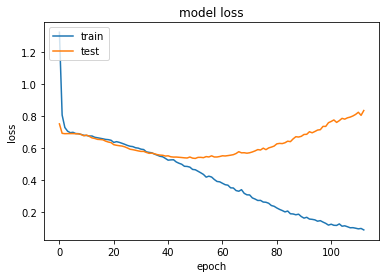

In [21]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

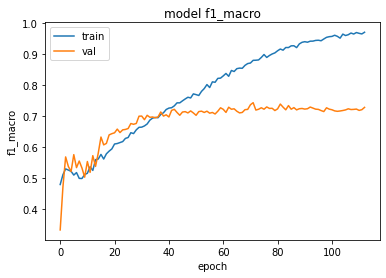

In [22]:
# summarize history for loss
plt.plot(history.history['f1_macro'])
plt.plot(history.history['val_f1_macro'])
plt.title('Model f1_macro')
plt.ylabel('f1_macro')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# ensemble predictions

In [18]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import scipy

In [15]:
cv_kfold = StratifiedKFold(n_splits=5, shuffle=True)

models = []

for train_index, test_index in cv_kfold.split(X_e, y):
  input_train_k = X_e[train_index]
  input_val_k   = X_e[test_index]
  y_train_k = y[train_index]
  y_val_k = y[test_index]

  model = kim_cnn((65,128, ), filters = 256, filter_sizes = [2,3,4], dropout = 0.4, hn=64, lr=0.0001, print_model=False)

  f1_callback = FCallback(validation = (input_val_k, y_val_k), verbose=False)    
  best_callback = ReturnBestEarlyStopping(monitor="val_loss", min_delta=0, patience=50, verbose=1, mode="min", restore_best_weights=True)

  history = model.fit(input_train_k, y_train_k, batch_size=128, epochs=200, validation_data=(input_val_k, y_val_k), callbacks=[f1_callback, best_callback], verbose = 0)
  
  y_val_pred_k = np.where(model.predict(input_val_k) >0.5,1,0)
  print(f1_score(y_val_k,y_val_pred_k,average="macro"))
  models.append(model)


Restoring model weights from the end of the best epoch.

Epoch 101: early stopping
0.7036266735993761
Restoring model weights from the end of the best epoch.

Epoch 102: early stopping
0.683991683991684
Restoring model weights from the end of the best epoch.

Epoch 104: early stopping
0.7138908959635193
Restoring model weights from the end of the best epoch.

Epoch 109: early stopping
0.7084478801787655
Restoring model weights from the end of the best epoch.

Epoch 101: early stopping
0.6953496434231379


In [16]:
def ensemble_predictions(members, X):
  # make predictions
  results = []
  yhats = [np.squeeze(np.where(models[0].predict(X) > 0.5, 1,0).reshape(1,-1)) for model in members]
  # sum across ensemble members
  yhats = np.array(yhats)
  print(yhats[:,0])
  print(yhats.shape)

  for i in range(yhats.shape[1]):
    counts = np.bincount(yhats[:,i])
    results.append(np.argmax(counts))
  # argmax across classes
  return results

def ensemble_predictions2(models, test):
  # Predict labels with models
  labels = []
  for m in models:
      predicts = np.argmax(m.predict(test), axis=1)
      labels.append(predicts)
      
  # Ensemble with voting
  labels = np.array(labels)
  labels = np.transpose(labels, (1, 0))
  labels = scipy.stats.mode(labels, axis=-1)[0]
  labels = np.squeeze(labels)

In [20]:
y_pred = ensemble_predictions(models, X_test_e)
print(classification_report(y_test,y_pred))


[0 0 0 0 0]
(5, 1263)
              precision    recall  f1-score   support

           0       0.81      0.55      0.66       694
           1       0.61      0.84      0.70       569

    accuracy                           0.68      1263
   macro avg       0.71      0.70      0.68      1263
weighted avg       0.72      0.68      0.68      1263

